In [11]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Planning: TODO Lists

Many agents use TODO lists as a critical navigation tool for steering through long-running, complex tasks. Claude Code leverages [plan mode](https://www.anthropic.com/engineering/claude-code-best-practices) to create structured TODO lists before executing tasks, utilizing a specific tool called `TodoWrite` based on the [Claude Code prompt](https://cchistory.mariozechner.at/). Each TODO item contains three key components: content (a short, specific task description), status (pending, in_progress, or completed), and a unique identifier for tracking progress.

The challenge with TODO lists lies in maintaining attention as context windows grow—the average Manus task uses approximately 50 tool calls, creating substantial risk of [context rot](https://research.trychroma.com/context-rot). Agents become vulnerable to drifting off-topic or forgetting earlier objectives during lengthy conversations or complicated tasks. By continuously rewriting and updating the TODO list, agents like Manus effectively recite their objectives at the end of the context, helping to [stay focused on task](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and prevent mission drift.

### State

**TODO(Geoff)** Can explain here that we define the state object 
* Explain `AgentState` (`langgraph.prebuilt.chat_agent_executor import AgentState`)
* Explain with `todo` we will simple overwrite the state with each tools call. 
* Explain `files` and `file_reducer`. 

In [ ]:
%%writefile ../src/deep_agents_from_scratch/state.py

from typing import Annotated, Literal, NotRequired, TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """
    content: str
    status: Literal["pending", "in_progress", "completed"]

def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}

class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """
    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

### Tool Description  

**TODO(Geoff)** Here we can explain how the tool will be used.


In [14]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create and manage structured task lists for tracking progress through complex workflows.                       │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions                                                                            │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list.                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Write and Read ToDo Tools 

**TODO(Geoff)** 
* Carefully explain what is happening when return `Command` type from a tool call. 
* We are using this to update the graph state! 
* Normally, from a tool call we just return a string.
* This will be packaged as a `ToolMessage` and added to `messages` key.
* This is done w/ `create_react_agent` prebuilt. 
* `Command` is executed by the graph and a tool can update various keys in graph state. 

For the read tool, we can just return a string. 
* This takes advantage of LangGraph persistence! 
* We can always get TODOs from state. 
* This ensures the agent does not loose track of them! 

In [27]:
%%writefile ../src/deep_agents_from_scratch/todo_tools.py

from typing import Annotated
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo

@tool(description=WRITE_TODOS_DESCRIPTION)
def write_todos(
    todos: list[Todo], 
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Read the current TODO list from the agent state.
    
    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.
    
    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking
     
    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get('todos', [])
    if not todos:
        return "No todos currently in the list."
    
    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo['status'], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"
    
    return result.strip()
    

Writing ../src/deep_agents_from_scratch/todo_tools.py


### Graph  

**TODO(Geoff)** 
* Here we can explain create_react_agent.
* Explain how it uses `state_schema` to define the state of the agent.
* Let's just focus on getting an agent to use the write and read TODOs tool clearly.
* We'll follow Manus's approach to TODO recitation after each task.
* We'll use a list of TODOs written as tool calls, similar to Claude Code.

In [24]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  │                                                                                                              │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

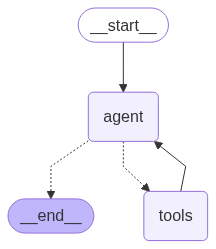

In [28]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from tavily import TavilyClient
from utils import format_messages

from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tools import read_todos, write_todos


@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.
    
    This tool uses Tavily to perform web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.
    
    Args:
        query: The search query string. Be specific and clear about what 
               information you're looking for.
    
    Returns:
        Search results from Tavily including titles, URLs, and content snippets
        from relevant web pages.
        
    Example:
        web_search("machine learning applications in healthcare")
    """
    tavily_client = TavilyClient()
    search_results = tavily_client.search(
        query,
        max_results=5,
        include_raw_content=False,
        topic="general",
    )
    return search_results

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [write_todos, web_search, read_todos]

# Create agent with system prompt
agent = create_react_agent(model, tools, prompt=TODO_USAGE_INSTRUCTIONS+"\n\n"+"Use web_search to find information.", state_schema=DeepAgentState)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `todos` in state and an user research request. 

In [26]:
# Example usage
result = agent.invoke({
    "messages": [{"role": "user", "content": "Give me an overview of Model Context Protocol (MCP)."}],
    "todos": []
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get an overview of Model Context Protocol (MCP). Let me start by creating a research plan and     │
│ then gathering the information.                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview of MCP findings",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01XEnZPTbiQ2Qb7UdgqNHDwU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ and current status', 'status': 'pending'}, {'content': 'Compile comprehensive overview of MCP findings',        │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me start researching Model Context Protocol.                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview of MCP findings",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_012jSn7e83rMLmDMrn8uvTq5                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ and current status', 'status': 'in_progress'}, {'content': 'Compile comprehensive overview of MCP findings',    │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP definition purpose features"                                             │
│ }                                                                                                               │
│    ID: toolu_018AmjqTZfuHPGnynaG8fLPf                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"query": "Model Context Protocol MCP definition purpose features", "follow_up_questions": null, "answer":      │
│ null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Model_Context_Protocol", "title": "Model │
│ Context Protocol - Wikipedia", "content": "The **Model Context Protocol** (**MCP**) is an open standard,        │
│ open-sourceframework introduced by Anthropic in November 2024 to standardize the way artificial intelligence    │
│ (AI) systems like large language models (LLMs) integrate and share data with external tools, systems, and data  │
│ sources. The protocol was announced by Anthropic in November 2024 as an open standard for connecting AI         │
│ assistants to data systems such as content repositories, business management tools, and development             │
│ environments. Demis Hassabis, CEO of Google DeepMind, confirmed in April 2025 MCP support in the upcoming       │
│ Gemini \"Gemini (chatbot)\") models and related infrastructure, describing the protocol as \"rapidly becoming   │
│ an open standard for the AI agentic era\".", "score": 0.98525, "raw_content": null}, {"url":                    │
│ "https://www.anthropic.com/news/model-context-protocol", "title": "Introducing the Model Context Protocol -     │
│ Anthropic", "content": "*   Claude Today, we're open-sourcing the Model Context Protocol (MCP), a new standard  │
│ for connecting AI assistants to the systems where data lives, including content repositories, business tools,   │
│ and development environments. The Model Context Protocol is an open standard that enables developers to build   │
│ secure, two-way connections between their data sources and AI-powered tools. Claude 3.5 Sonnet is adept at      │
│ quickly building MCP server implementations, making it easy for organizations and individuals to rapidly        │
│ connect their most important datasets with a range of AI-powered tools. All Claude.ai plans support connecting  │
│ MCP servers to the Claude Desktop app.", "score": 0.98313, "raw_content": null}, {"url":                        │
│ "https://www.descope.com/learn/post/mcp", "title": "What Is the Model Context Protocol (MCP) and How It Works", │
│ "content": "The **Model Context Protocol (MCP)** addresses this challenge by providing a standardized way for   │
│ LLMs to connect with external data sources and tools—essentially a “universal remote” for AI apps. 2.   **MCP   │
│ client:** Integrated within the host application to handle connections with MCP servers, translating between    │
│ the host’s requirements and the Model Context Protocol. Framework support has expanded to include integrations  │
│ for Firebase Genkit, LangChain adapters, and platforms like Superinterface, which helps developers build in-app │
│ AI assistants with MCP functionality. The MCP ecosystem comprises a diverse range of servers including          │
│ reference servers (created by the protocol maintainers as implementation examples), official integrations       │
│ (maintained by companies for their platforms), and community servers (developed by independent contributors).", │
│ "score": 0.98063, "raw_content": null}, {"url": "https://modelcontextprotocol.io/specification/2025-06-18",     │
│ "title": "Specification - Model Context Protocol", "content": "Model Context Protocol (MCP) is an open protocol │
│ that enables seamless integration between LLM applications and external data sources and tools. Whether you’re  │
│ building an AI-powered IDE, enhancing a chat interface, or creating custom AI workflows, MCP provides a         │
│ standardized way to connect LLMs with the context they need.This specification defines the authoritative        │
│ protocol requirements, based on the TypeScript schema in schema.ts.For implementation guides and examples,      │
│ visit modelcontextprotocol.io.The key words “MUST”, “MU

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about MCP's technical details and implementation.                   │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP technical architecture JSON-RPC servers clients"                         │
│ }                                                                                                               │
│    ID: toolu_014T2fZXgVBN7stEaMYotmzQ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"query": "Model Context Protocol MCP technical architecture JSON-RPC servers clients", "follow_up_questions":  │
│ null, "answer": null, "images": [], "results": [{"url":                                                         │
│ "https://modelcontextprotocol.io/docs/concepts/architecture", "title": "Architecture Overview - Model Context   │
│ Protocol", "content": "*   **Data layer**: Defines the JSON-RPC based protocol for client-server communication, │
│ including lifecycle management, core primitives, such as tools, resources, prompts and notifications. It can    │
│ expose tools for querying the database, a resource that contains the schema of the database, and a prompt that  │
│ includes few-shot examples for interacting with the tools.For more details about server primitives see server   │
│ concepts.MCP also defines primitives that _clients_ can expose. Notifications are sent as JSON-RPC 2.0          │
│ notification messages (without expecting a response) and enable MCP servers to provide real-time updates to     │
│ connected clients. This request is fundamental to MCP’s tool discovery mechanism — it allows clients to         │
│ understand what tool are available on the server before attempting to use them. This notification pattern       │
│ extends beyond tools to other MCP primitives, enabling comprehensive real-time synchronization between clients  │
│ and servers.", "score": 0.90771407, "raw_content": null}, {"url":                                               │
│ "https://www.truefoundry.com/blog/inside-the-model-context-protocol-mcp-architecture-motivation-internal-usage" │
│ , "title": "Inside the Model Context Protocol (MCP): Architecture, Motivation ...", "content": "At its core,    │
│ MCP follows a JSON-RPC-based client-server architecture where a host application can connect to multiple        │
│ servers: MCP Hosts are LLM", "score": 0.8793233, "raw_content": null}, {"url":                                  │
│ "https://modelcontextprotocol.io/specification/2025-06-18/architecture", "title": "Architecture - Model Context │
│ Protocol", "content": "The Model Context Protocol (MCP) follows a client-host-server architecture where each on │
│ context exchange and sampling coordination between clients and servers. Server 1   Server 2   Server 3   Each   │
│ client is created by the host and maintains an isolated server connection: servers** The Model Context Protocol │
│ uses a capability-based negotiation system where clients and - Servers declare capabilities like resource       │
│ subscriptions, tool support, and prompt - Clients declare capabilities like sampling support and notification   │
│ handling ServerClientHostServerClientHostActive Session with Negotiated Featuresloop[Client                     │
│ Requests]loop[Server Requests]loop[Notifications]Initialize clientInitialize session with capabilitiesRespond   │
│ with supported capabilitiesUser- or model-initiated actionRequest (tools/resources)ResponseUpdate UI or respond │
│ to modelRequest (sampling)Forward to AIAI responseResponseResource updatesStatus changesTerminateEnd session    │
│ server’s capabilities This capability negotiation ensures clients and servers have a clear understanding of -   │
│ Servers", "score": 0.85157084, "raw_content": null}, {"url":                                                    │
│ "https://themlarchitect.com/blog/the-architectural-elegance-of-model-context-protocol-mcp/", "title": "The      │
│ Architectural Elegance of Model Context Protocol (MCP)", "content": "**The Model Context Protocol (MCP)         │
│ architecture simplifies AI integration complexity using clear architectural patterns, including Facade/API      │
│ Gateway, Adapter, Sidecar, and Orchestrator. Image 5: This sequence diagram illustrates how the Model Context   │
│ Protocol (MCP) facilitates seamless integration between

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more information about MCP's use cases and ecosystem.                                         │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "\"Model Context Protocol\" MCP use cases examples ecosystem servers"                                │
│ }                                                                                                               │
│    ID: toolu_016rLrMDdUaBHmkXiB5LZ7gs                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"query": "\"Model Context Protocol\" MCP use cases examples ecosystem servers", "follow_up_questions": null,   │
│ "answer": null, "images": [], "results": [{"url": "https://www.descope.com/learn/post/mcp", "title": "What Is   │
│ the Model Context Protocol (MCP) and How It Works", "content": "The **Model Context Protocol (MCP)** addresses  │
│ this challenge by providing a standardized way for LLMs to connect with external data sources and               │
│ tools—essentially a “universal remote” for AI apps. 2.   **MCP client:** Integrated within the host application │
│ to handle connections with MCP servers, translating between the host’s requirements and the Model Context       │
│ Protocol. Framework support has expanded to include integrations for Firebase Genkit, LangChain adapters, and   │
│ platforms like Superinterface, which helps developers build in-app AI assistants with MCP functionality. The    │
│ MCP ecosystem comprises a diverse range of servers including reference servers (created by the protocol         │
│ maintainers as implementation examples), official integrations (maintained by companies for their platforms),   │
│ and community servers (developed by independent contributors).", "score": 0.8332299, "raw_content": null},      │
│ {"url":                                                                                                         │
│ "https://milvus.io/ai-quick-reference/what-are-hosts-clients-and-servers-in-the-model-context-protocol-mcp-ecos │
│ ystem", "title": "What are hosts, clients, and servers in the Model Context ...", "content": "* What are hosts, │
│ clients, and servers in the Model Context Protocol (MCP) ecosystem? # What are hosts, clients, and servers in   │
│ the Model Context Protocol (MCP) ecosystem? In the Model Context Protocol (MCP) ecosystem, **hosts**,           │
│ **clients**, and **servers** are distinct components that work together to enable distributed machine learning  │
│ workflows. A **server** acts as an intermediary, coordinating communication between clients and hosts while     │
│ managing tasks like load balancing, authentication, or result aggregation. For example, if a client requests a  │
│ ResNet-50 inference task, the server could route it to a GPU-equipped host optimized for vision models. In      │
│ advanced setups, servers orchestrate multi-step pipelines, such as preprocessing data on one host, running      │
│ inference on another, and logging results to a database—all within a single client request.", "score":          │
│ 0.82288796, "raw_content": null}, {"url":                                                                       │
│ "https://medium.com/@laowang_journey/model-context-protocol-mcp-real-world-use-cases-adoptions-and-comparison-t │
│ o-functional-calling-9320b775845c", "title": "Model Context Protocol (MCP) real world use cases ...",           │
│ "content": "Local/Remote Resources: The actual data sources or services that MCP servers interface with — these │
│ can be local (files, databases, applications on your machine) or remote (web APIs, cloud services) (Anthropic’s │
│ Model Context Protocol(MCP): An Open Source Model to Bridge AI and Data Access). For example, if a model tries  │
│ to use a tool, the client UI will typically prompt the user “Allow tool X to run?” before forwarding the        │
│ request to the server (Model Context Protocol (MCP): The Future of LLM Function Calling | Greg Hilston). By     │
│ implementing MCP, companies like Replit, Codeium, and others are aiming to support multiple AI backends with    │
│ the same toolset (Introducing the Model Context Protocol \\ Anthropic) — e.g., the same MCP server can serve a  │
│ Codeium (which might use their own model) or Claude.", "score": 0.79369855, "raw_content": null}, {"url":       │
│ "https://modelcontextprotocol.io/examples", "title": "E

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_019FwrCVAcE9D5UuiUtsBoBj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 Research Model Context Protocol (MCP) - definition, purpose, key features, and current status             │
│ (in_progress)                                                                                                   │
│ 2. ⏳ Compile comprehensive overview of MCP findings (pending)                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I have gathered comprehensive information about MCP. Let me mark the research task as completed and move to │
│ compiling the overview.                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview of MCP findings",                                              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01QAQGz7Wo4YXMKTJmCsgAck                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview of MCP findings',      │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-source standard introduced by Anthropic in November 2024 that   │
│ standardizes how AI systems, particularly Large Language Models (LLMs), integrate and share data with external  │
│ tools, systems, and data sources. Think of it as a "universal remote" for AI applications that need to connect  │
│ with various external services and data.                                                                        │
│                                                                                                                 │
│ ## Purpose and Problem Solved                                                                                   │
│                                                                                                                 │
│ MCP addresses a critical challenge in AI development: the complexity of connecting AI applications to diverse   │
│ external systems. Before MCP, developers had to create custom integrations for each combination of AI           │
│ application and external service, leading to an N×M integration problem. MCP solves this by providing a         │
│ standardized protocol where:                                                                                    │
│                                                                                                                 │
│ - **Tool creators** build N MCP servers (one for each system)                                                   │
│ - **Application developers** build M MCP clients (one for each AI application)                                  │
│ - This reduces integration complexity from N×M to N+M connections                                               │
│                                                                                                                 │
│ ## Architecture                                                                                                 │
│                                                                                                                 │
│ MCP follows a **client-host-server architecture** built on JSON-RPC 2.0:                                        │
│                                                                                                                 │
│ ### Core Components:                                                                                            │
│                                                                                                                 │
│ 1. **Host**: The main AI application (like Claude Desktop, IDE, or chatbot)                                     │
│ 2. **Client**: Lives within the host application and manages connections to MCP servers                         │
│ 3. **Server**: External programs that expose capabilities (tools, resources, prompts) to AI models              │
│                                                                                                                 │
│ ### Key Features:                                                                                               │
│                                                                                                                 │
│ - **JSON-RPC based communication**: Standardized protocol for client-server interaction                         │
│ - **Capability-based negotiation**: Clients and servers

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview of MCP findings',      │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ This overview covers the essential aspects of the Model Context Protocol, from its technical architecture to    │
│ its growing ecosystem and real-world applications. MCP represents a significant step toward standardizing       │
│ AI-external system integrations, making it easier for developers to build powerful AI applications that can     │
│ seamlessly interact with various data sources and tools.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/55ab24cc-1f2f-4df2-aa24-405f87845fad/r